# импорты

In [109]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# константы

In [2]:
RANDOM_STATE = 1909
SHUFFLE = True
TEST_SIZE = 0.3


# загрузка данных

In [3]:
data = pd.read_excel("экзамен задание.xlsx")
columns = data.columns.tolist()


# смотрим данные

In [4]:
print(data.shape)
data.head()


(82, 6)


,Область,Гражданам России по территории России,среднедушевые доходы населения,среднемесячная заработная плата номинальная,Реальная среднемесячная начисленная заработная %,"Доходы коллективных средств размещения от предоставляемых услуг без НДС, акцизов и аналогичных платежей"
0,Белгородская область,5462,32840.649407,37442,104.804339,1357670.0
1,Брянская область,2336,28596.023702,31946,102.944006,855931.7
2,Владимирская область,4282,25922.182283,35240,102.998066,1751496.8
3,Воронежская область,3500,32077.841606,36317,103.187518,2012401.6
4,Ивановская область,4167,26277.285855,29083,101.636189,1011140.2


In [5]:
# типы значений (задача регрессии)
data.dtypes


Область                                                                                                     object
Гражданам России по территории России                                                                        int64
среднедушевые доходы населения                                                                             float64
среднемесячная заработная плата номинальная                                                                  int64
Реальная среднемесячная начисленная заработная %                                                           float64
Доходы коллективных средств размещения от предоставляемых услуг без НДС, акцизов и аналогичных платежей    float64
dtype: object

In [6]:
# пропусков нет
data.isna().sum()


Область                                                                                                    0
Гражданам России по территории России                                                                      0
среднедушевые доходы населения                                                                             0
среднемесячная заработная плата номинальная                                                                0
Реальная среднемесячная начисленная заработная %                                                           0
Доходы коллективных средств размещения от предоставляемых услуг без НДС, акцизов и аналогичных платежей    0
dtype: int64

# посмотрим гистограмму таргета

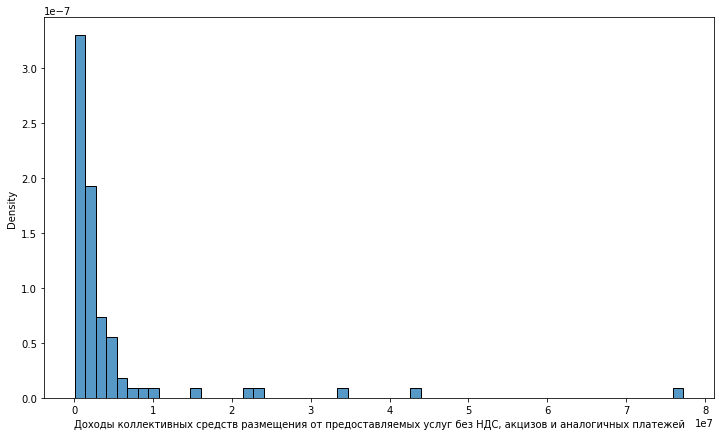

In [7]:
plt.figure(figsize=(12, 7))
sns.histplot(data[columns[-1]], stat="density")
plt.show()


Распределение напоминает лог-нормальное.

Попробуем его логарифмировать (в конце будем потенцировать обратно).

In [8]:
y_log, lambda_y = boxcox(data[columns[-1]])


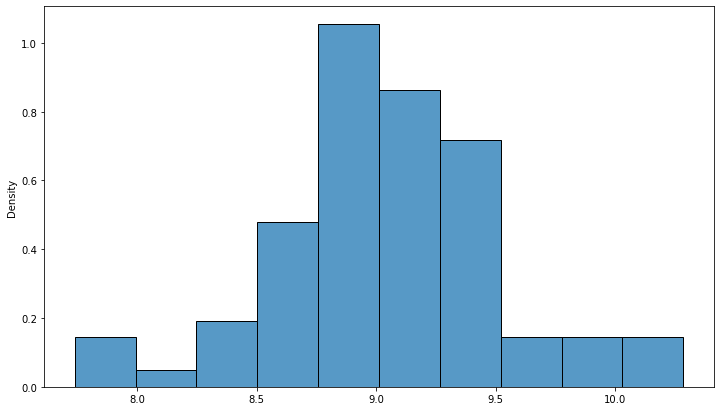

In [9]:
plt.figure(figsize=(12, 7))
sns.histplot(y_log, stat="density")
plt.show()


Выглядит намного лучше.

Проверим признаки.

In [10]:
# удаляю признак "Область", потому что он избыточен
data.drop("Область", axis=1, inplace=True)
columns = data.columns.tolist()


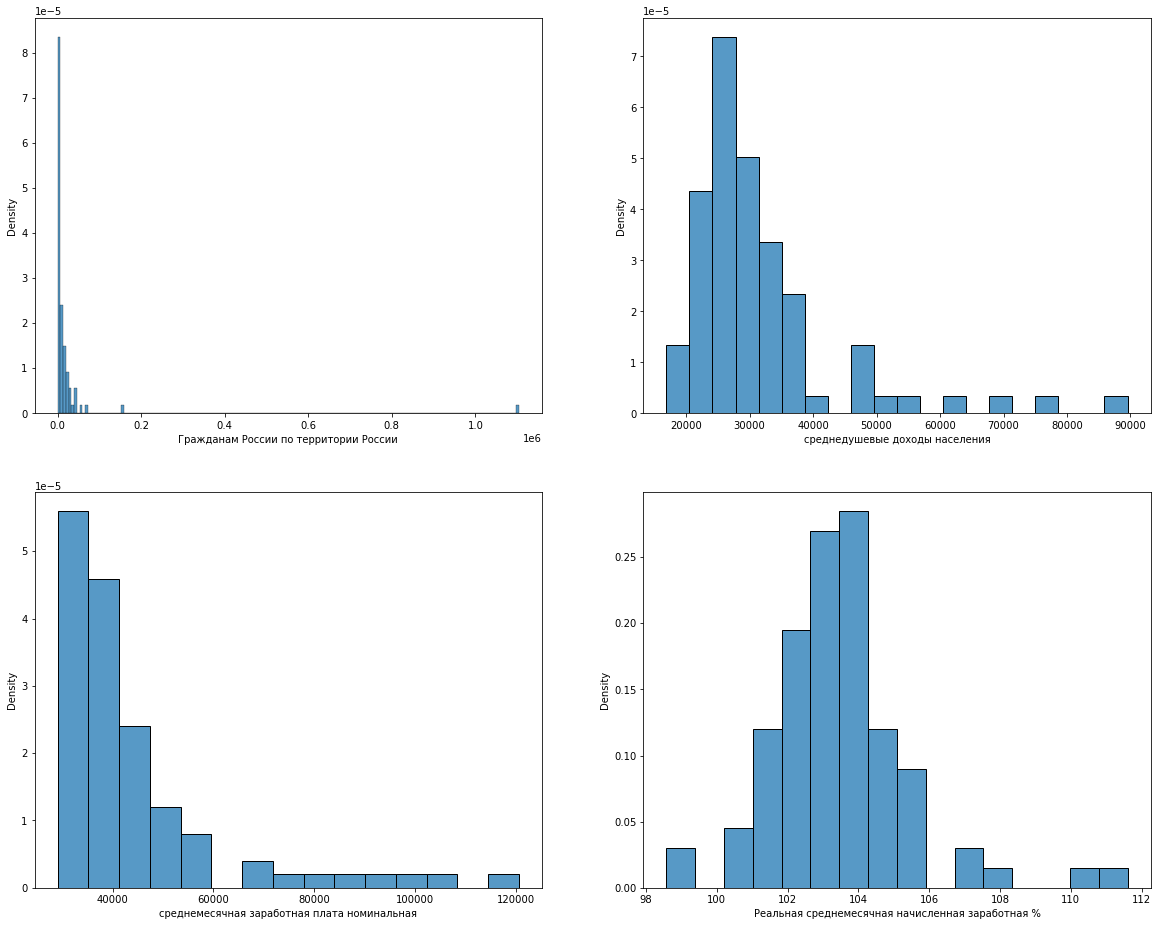

In [11]:
f, axs = plt.subplots(2, 2)
f.set_size_inches(20, 16)
for i in range(2):
    for j in range(2):
        sns.histplot(data[columns[i * 2 + j]], stat="density", ax=axs[i][j])
plt.show()


Попробуем логарифмировать всё, кроме "Реальная среднемесячная начисленная заработная %"

In [48]:
lambda_x = []
X_log = pd.DataFrame()

for col in columns[:-2]:
    x_log, l = boxcox(data[col])
    X_log[col] = x_log
    lambda_x.append(l)
X_log[columns[-2]] = data[columns[-2]]


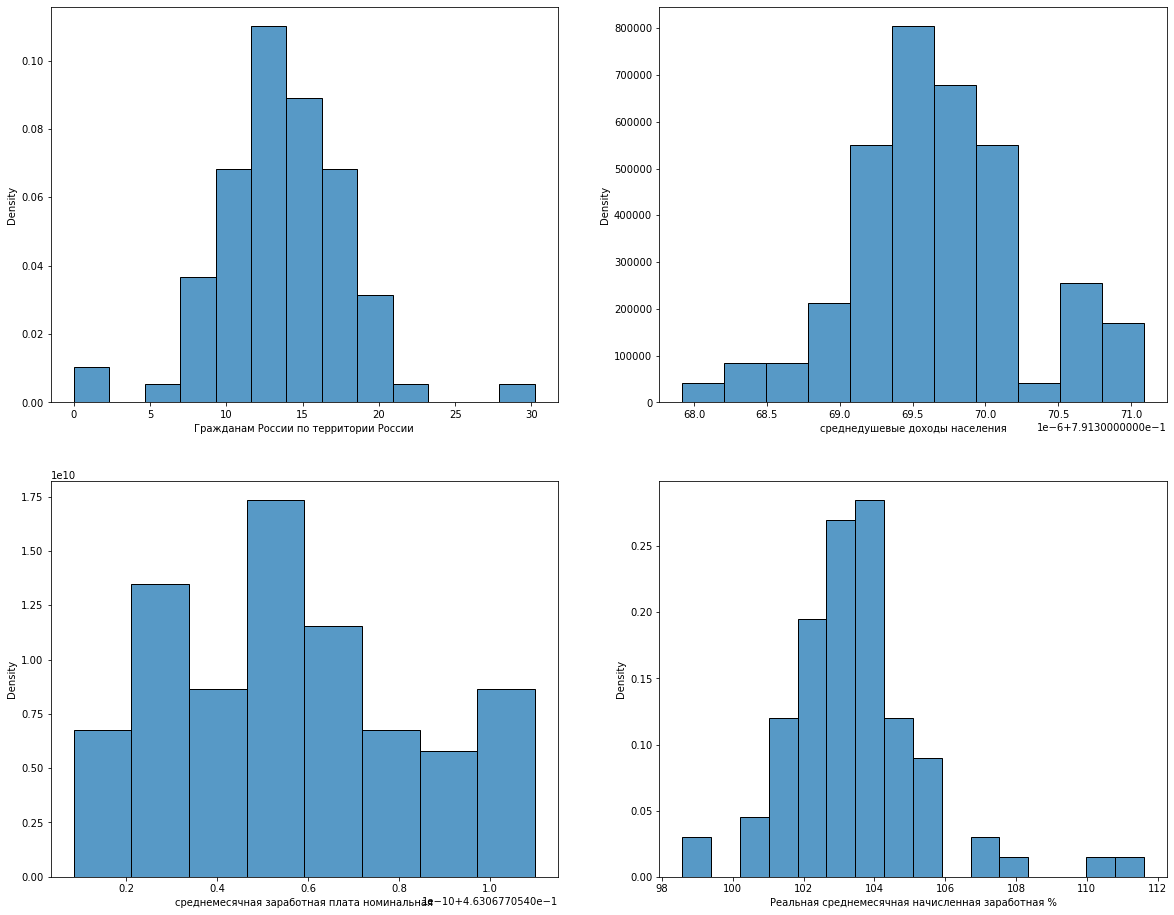

In [49]:
f, axs = plt.subplots(2, 2)
f.set_size_inches(20, 16)
for i in range(2):
    for j in range(2):
        sns.histplot(X_log[columns[i * 2 + j]], stat="density", ax=axs[i][j])
plt.show()


Чудесно.

# подготовим данные

1. Уберём признак "Область", потому что это он уникальный для каждой записи. (уже убрали в коде выше)
2. Поделим данные на X (характеристики областей) и y (таргет).
3. Поделим данные на train и test 70% и 30%.
4. Посчитаем попарную корреляцию Спирмена или Пирсона. Будем считать признаки сильно скоррелированными, если коэффициент корреляции будет по модулю больше 0.7. Из группы скоррелированных оставим тот признак, коэффициент корреляции с таргетом у которого по модулю будет больше.



In [69]:
X = data[columns[:-1]]
y = data[columns[-1]]


In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    shuffle=SHUFFLE,
    random_state=RANDOM_STATE,
)


1. логарифмируем train и сохраняем lambda на будущее для теста и для обратного преобразования после предикта
2. логарифмируем test с уже фиксированной lambda

In [71]:
lambda_x = []
X_train_log = pd.DataFrame()

for col in columns[:-2]:
    x_log, l = boxcox(X_train[col])
    X_train_log[col] = x_log
    lambda_x.append(l)
X_train_log.index = X_train.index
X_train_log[columns[-2]] = X_train[columns[-2]]


In [72]:
X_test_log = pd.DataFrame()

for i, col in enumerate(columns[:-2]):
    x_log = boxcox(X_test[col], lmbda=lambda_x[i])
    X_test_log[col] = x_log
X_test_log.index = index = X_test.index
X_test_log[columns[-2]] = X_test[columns[-2]]


In [84]:
y_train_log, lambda_y = boxcox(y_train)
y_test_log = boxcox(y_test, lambda_y)

y_train_log, y_test_log = list(map(pd.Series, [y_train_log, y_test_log]))
y_train_log.name, y_test_log.name = [columns[-1]] * 2


## Корреляция Пирсона


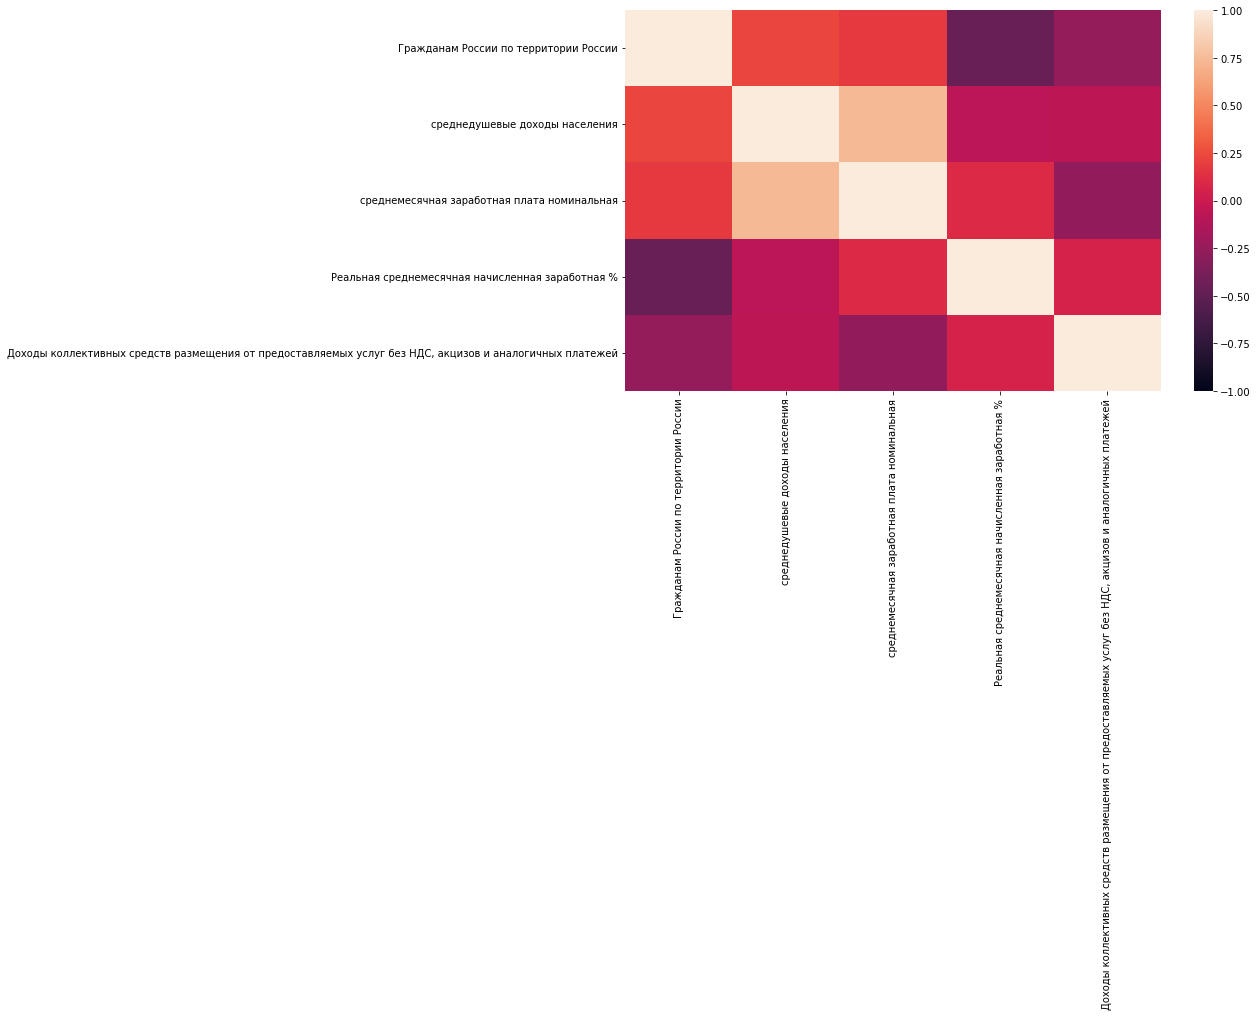

In [85]:
plt.figure(figsize=(12, 7))
sns.heatmap(
    pd.concat([X_train_log, y_train_log], axis=1).corr(method="pearson"),
    vmax=1,
    vmin=-1,
)
plt.show()


Видим, что признаки "среднедушевые доходы населения" и "среднемесячная заработная плата номинальная" скоррелированы на 0.72 (сильно).

Признак "среднемесячная заработная плата номинальная" коррелирует с таргетом больше, поэтому оставляем его.


## Корреляция Спирмена

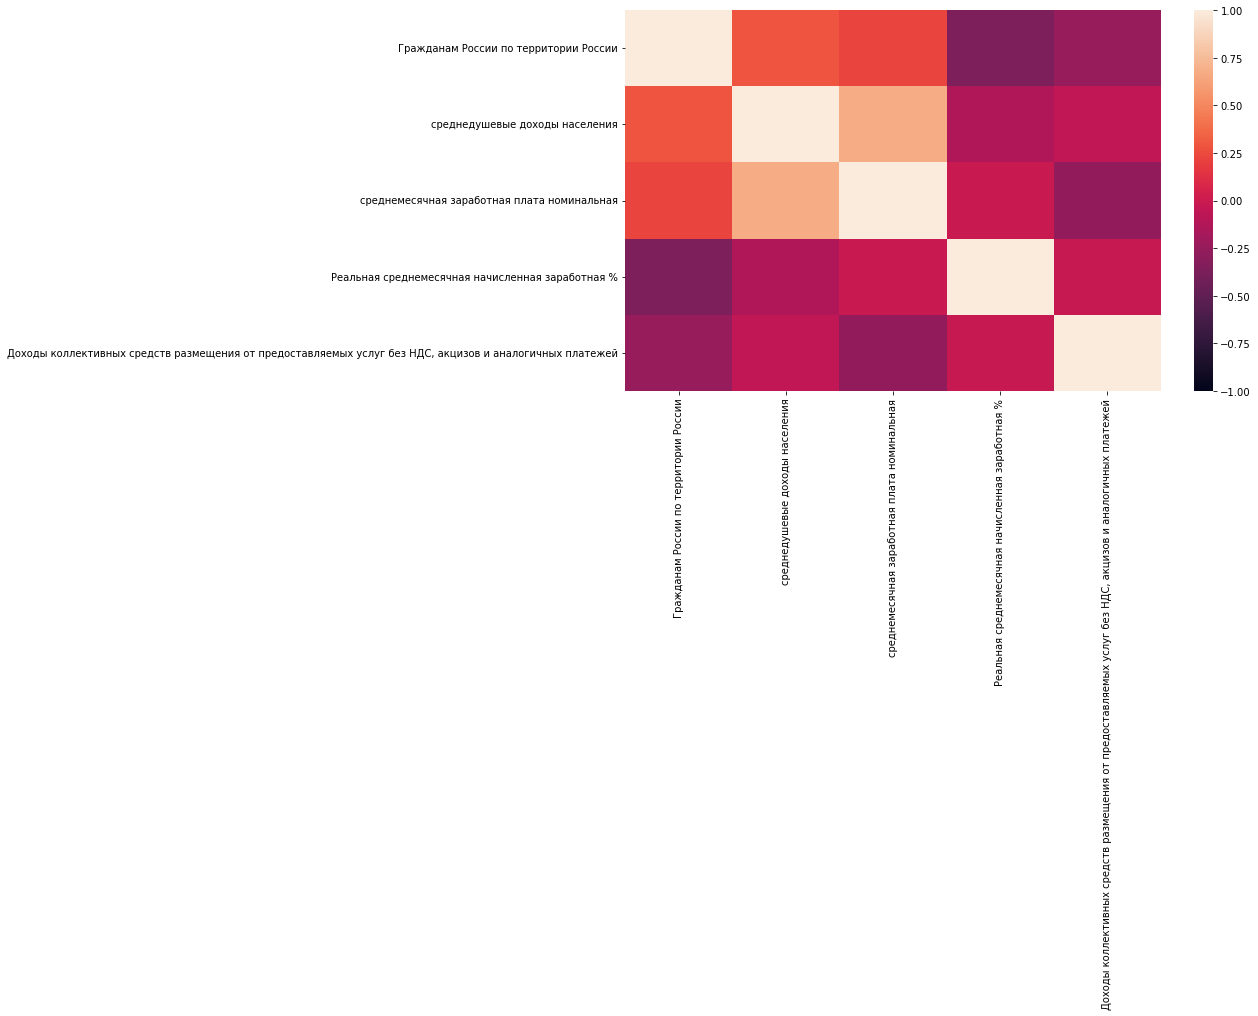

In [87]:
plt.figure(figsize=(12, 7))
sns.heatmap(
    pd.concat([X_train_log, y_train_log], axis=1).corr(method="spearman"),
    vmax=1,
    vmin=-1,
)
plt.show()


Ситуация ровно такая же.

## Удаляем признак "среднедушевые доходы населения"

In [89]:
columns_to_drop = ["среднедушевые доходы населения"]

X_train.drop(columns_to_drop, axis=1, inplace=True)
X_test.drop(columns_to_drop, axis=1, inplace=True)

X_train_log.drop(columns_to_drop, axis=1, inplace=True)
X_test_log.drop(columns_to_drop, axis=1, inplace=True)


## Стандартизируем признаки

In [101]:
scaler = StandardScaler()
X_train_log_scaled = scaler.fit_transform(X_train_log)
X_test_log_scaled = scaler.transform(X_test_log)


## обучаем модель линейной регрессии

In [107]:
model = LinearRegression()
model.fit(X_train_log_scaled, y_train_log)


LinearRegression()

# Коэффициенты уравнения линейной регрессии. Xw + b = y

In [108]:
print(f"Веса при признаках: {model.coef_}")
print(f"Смещение: {model.intercept_}")


Веса при признаках: [ 0.09745693  0.0079578  -0.0112468 ]
Смещение: 5.4800385297729175


# Замерим метрику MAPE

In [118]:
y_pred_log = model.predict(X_test_log_scaled)
y_pred = inv_boxcox(y_pred_log, lambda_y)
print(
    f"MAPE на отложенной тестовой выборке: {mean_absolute_percentage_error(y_test, y_pred)}"
)


MAPE на отложенной тестовой выборке: 0.627632377921256


Средняя ошибка составляет 0.6% от абсолютной величины целевой переменной.

Я считаю это хорошим результатом.

# Вывод

1. Признаки **'Гражданам России по территории России', 'среднедушевые доходы населения', 'среднемесячная заработная плата номинальная' и 'Доходы коллективных средств размещения от предоставляемых услуг без НДС, акцизов и аналогичных платежей'** (таргет) оказались распределены примерно лог-нормально и все они были строго положительными ==> мы применили преобразование Бокса-Кокса (логарифмирование). А после предсказания моделью мы применили обратное преобразование с теми же параметрами.
2. При изменении логарифмов признаков **"Гражданам России по территории России", "среднемесячная заработная плата номинальная",	"Реальная среднемесячная начисленная заработная %"** на **единицу**, таргет меняется на **0.0974, 0.008 и -0.0112** соответственно - смысл уравнения лейной регрессии для целевой переменной **"Доходы коллективных средств размещения от предоставляемых услуг без НДС, акцизов и аналогичных платежей"**
